# Caso 1D
$$y''=-y$$
$$y(0) = 0$$
$$y(\pi/2) = 1$$

## Orden
1. importación de librerias
2. definición de los puntos de prueba y función de recorrido

### Importación de bibliotecas

In [32]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import random as rd
import numpy as np
import time
from typing import List
import timeit

device = "cuda"
dtype = torch.float64
puntosCreados = []
class NeuralNetworkPrueba(nn.Module):
    def __init__(self):
        super(NeuralNetworkPrueba, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


#red=NeuralNetworkPrueba().to(device)
#red.load_state_dict(torch.load("intento1Seno.txt")())
redDinamica = NeuralNetworkPrueba().to(device)

### Definición de los puntos de prueba y función de recorrido

In [60]:

puntos = torch.linspace(0,7,20, device = device)
puntos.requires_grad = True
perdidavar = 1e9
promAct = 0 
xsup = 7
def limitador(x):
    xint = x
    while (xint>xsup):
        xint -= xsup
    return xint
    
def actualizarPuntos():
    # Esta función va actualizar los puntos. Para mantener un balance entre puntos nuevos y puntos anteriores
    #  tambien va a cubir el espacio recorrido por puntos anteriores. Un objetivo de esta función es correr 
    # con un numero bajo de puntos
    global perdidavar,puntos,puntosCreados,promAct
    coeficiente = 1e-6 #este coeficiente es para alentizar el avance con respecto a la función de perdiad
    nuevosPuntos = puntos.detach().tolist()
    promAct = limitador(promAct+coeficiente/perdidavar*len(puntos))  # acá se da el avance en promedio
    print("promedio actual ", promAct)
    print("perdida actual  ", perdidavar)
    print("avance          ", coeficiente/perdidavar*len(puntos))
    nuevoPunto = max(min(rd.normalvariate(promAct,0.1),10),0) # acá se da el avance como una distribución normal
    nuevosPuntos.append(nuevoPunto)
    puntosCreados.append(nuevoPunto)
    tamTensor = 140
    borra = 40
    anade = 25
    if len(nuevosPuntos)>tamTensor:
        for i in range(borra):
            indice = rd.randint(0,tamTensor-borra-2)
            nuevosPuntos.pop(indice)
        for i in range(anade):
            nuevosPuntos.append(rd.uniform(0,promAct))
    puntos = torch.tensor(nuevosPuntos,device = device)
    puntos.requires_grad = True

### Definición de las funciones de perdida seriales

In [ ]:
def perdidaBase():
    suma=0
    xPi = torch.linspace(3.14159/2,1,2,device = device)
    xPi =  torch.tensor([xPi[0]],device=device,requires_grad =True)
    x0 =  torch.tensor([puntos[0]],device=device,requires_grad =True)
    suma+=40*(redDinamica(x0))**2
    suma+=100*(1-redDinamica(xPi))**2
    return suma


def perdida2():
    global perdidavar
    x0 =  torch.tensor([puntos[0]],device=device,requires_grad =True)
    xPi = torch.linspace(3.14159/2,1,2,device = device)
    xPi =  torch.tensor([xPi[0]],device=device,requires_grad =True)
    suma = 0
    for j in puntos:
        i = torch.tensor([j],device=device,requires_grad =True)
        y = redDinamica(i)
        yprima=torch.autograd.grad(y,i,create_graph=True)[0]
        yprimaprima=torch.autograd.grad(yprima,i,create_graph=True)[0]
        suma+=(yprimaprima+y)**2
    suma+=100*(redDinamica(x0))**2
    suma+=100*(1-redDinamica(xPi))**2
    perdidavar = suma
    return suma

superMax = 0


### Optimización usando las funciones de perdida seriales

to do 
- encontrar función para decidir cuando parar de optimizar
- probar con $\Delta _ {\text{promedio}}=\text{coeficiente}/\text{perdida}^2$

In [45]:
learning_rate = 1e-5
epochs = 8000
optimizer = torch.optim.Adam(redDinamica.parameters(), lr=learning_rate)
#registro_perdida=[]
tiempoInicial = time.time()
i = 0
while time.time()-tiempoInicial<3600/60*15:
    # Compute prediction and loss
    loss = perdida2()
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        print(loss.item()/len(puntos))
        #print("supermax",superMax)
        #actualizarPuntos()
    registro_perdida.append(loss.item()/len(puntos))
    i+=1

1.3229806518554688
1.2873484802246093
1.253108673095703
1.2203337860107422
1.189026870727539
1.1591458892822266
1.1306266021728515
1.1033957672119141
1.0773816680908204
1.0525161743164062
1.0287352752685548
1.0059808349609376
0.9841978454589844
0.9633358764648438
0.9433470153808594
0.9241876220703125
0.905815658569336
0.8881919860839844
0.8712791442871094
0.8550430297851562
0.839450454711914
0.824470443725586
0.8100736999511718
0.7962324523925781
0.7829205322265625
0.770113525390625
0.7577870941162109
0.7459199523925781
0.7344905090332031
0.7234790802001954
0.7128666687011719
0.7026350402832031
0.6927676391601563
0.6832479095458984
0.6740606689453125
0.6651914215087891
0.6566259765625
0.6483514404296875
0.6403550720214843
0.6326249694824219
0.6251498413085937
0.6179188156127929
0.6109215545654297
0.6041484069824219
0.5975899505615234
0.5912371826171875
0.585081672668457
0.5791155242919922
0.5733307647705078
0.5677199935913086
0.5622765350341797
0.5569933319091797
0.5518642425537109
0.5

KeyboardInterrupt: 

### Almacenamiento de los parametros de red obtenidos y gráficación de residuales

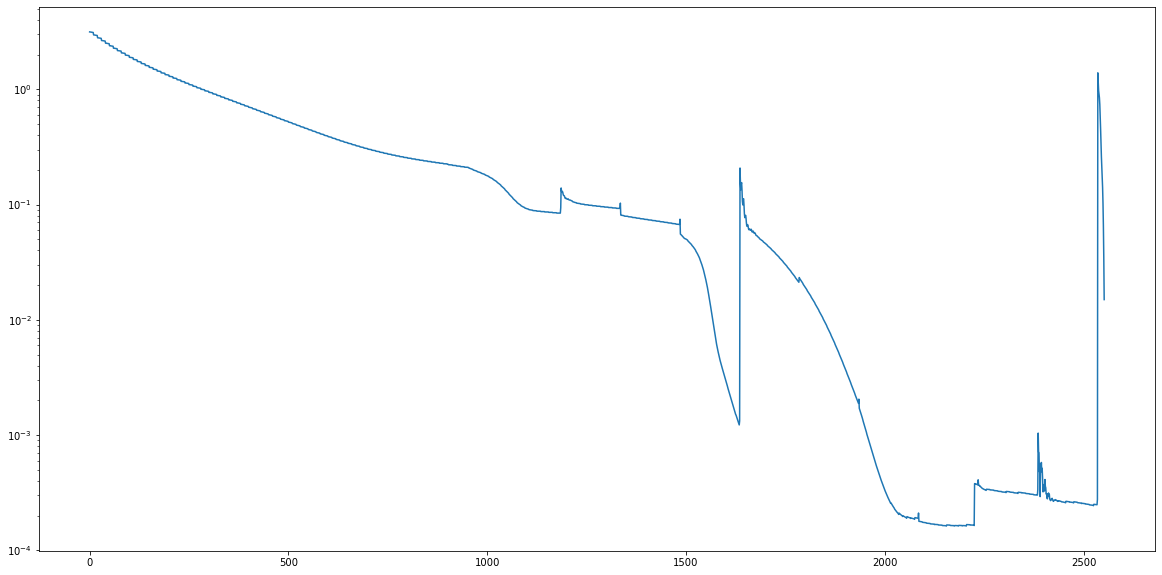

In [40]:
torch.save(redDinamica.state_dict(),"intento1SenoPuntosDinamicos.txt")
plt.figure(figsize = (20,10))
plt.semilogy(registro_perdida)

### Graficación de la respuesta obtenida vs la respuesta esperada

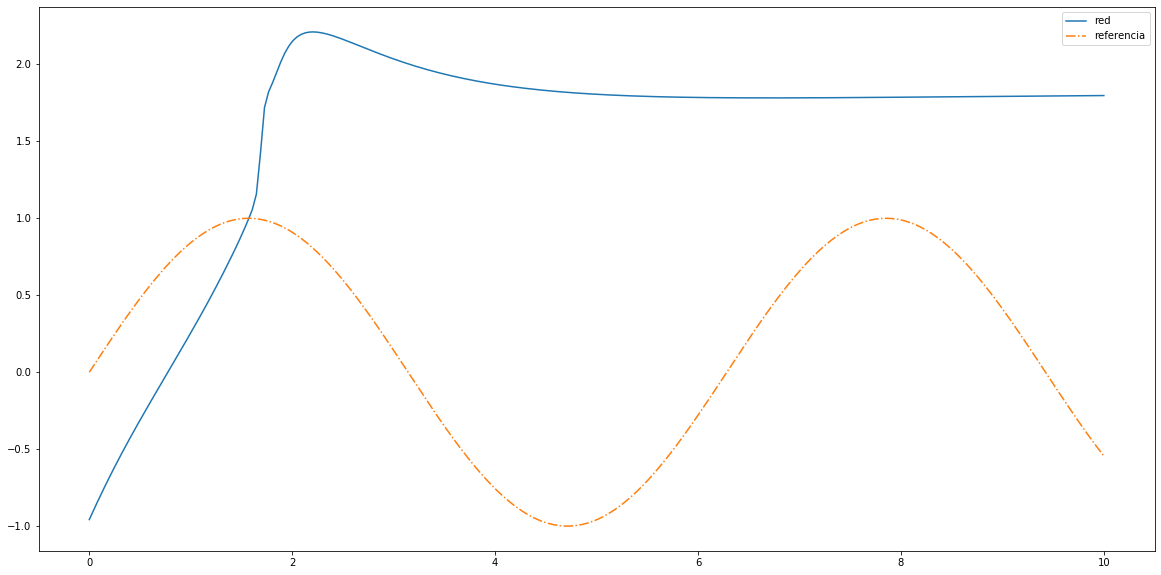

In [64]:
ygrafica = []
puntosGrafica = torch.linspace(0,10,250)
for i in puntosGrafica:
    ytemp=redDinamica(torch.tensor([i],device = device))
    ygrafica.append(ytemp.cpu().detach().numpy()[0])
    #ygrafica.append(ytemp.detach().numpy()[0])
import numpy as np
puntosGrafica = np.linspace(0,10,250)
plt.figure(figsize = (20,10))
plt.plot(puntosGrafica,ygrafica,label = "red")
plt.plot(puntosGrafica,np.sin(puntosGrafica),label = "referencia",LineStyle="-.")
plt.legend()

### Definición de la función de perdida paralelizada

In [34]:
def difeq(x):
    func = redDinamica
    x_in = torch.stack([x])
    y_temp = func(x_in)[0]
    #return y_temp
    der = torch.autograd.grad([y_temp,],[x_in,],create_graph=True)[0]
    if der is not None:
        segder = torch.autograd.grad([der,],[x_in,],create_graph=True)[0]
        if segder is not None:
            return (segder-y_temp)**2
        return x_in*0
    else:
        return x_in*0

@torch.jit.script
def miniPerdidaParalela(puntosLoc):
    futures : List[torch.jit.Future[torch.Tensor]] = []
    for punto in puntosLoc:
        futures.append(torch.jit.fork(difeq,punto))
    
    results = []
    for future in futures:
        results.append(torch.jit.wait(future))

    return torch.sum(torch.stack(results))


In [47]:
def perdidaParalela():
    global perdidavar	
    suma = 0
    x0 =  torch.tensor([puntos[0]],device=device,requires_grad =True)
    xPi = torch.linspace(3.14159/2,1,2,device = device)
    xPi =  torch.tensor([xPi[0]],device=device,requires_grad =True)
    suma += miniPerdidaParalela(puntos)
    suma+=100*(redDinamica(x0)[0])**2
    suma+=100*(1-redDinamica(xPi)[0])**2
    perdidavar = suma 
    return suma

### Comparación del rendimiento de la función de perdida paralelizada y serial

In [ ]:

tiempoSerial = []
tiempoParalelo = []
cantidadDePuntos = []
for n_loc in range(200):
    cantidadDePuntos.append((n_loc+1)*75)
    puntos = torch.linspace(0,7,(n_loc+1)*100, device = device)
    puntos.requires_grad = True
    tiempo0 = time.time()
    perdida2()
    tiempoSerial.append(time.time()-tiempo0)
    tiempo0 = time.time()
    perdidaParalela()
    tiempoParalelo.append(time.time()-tiempo0)

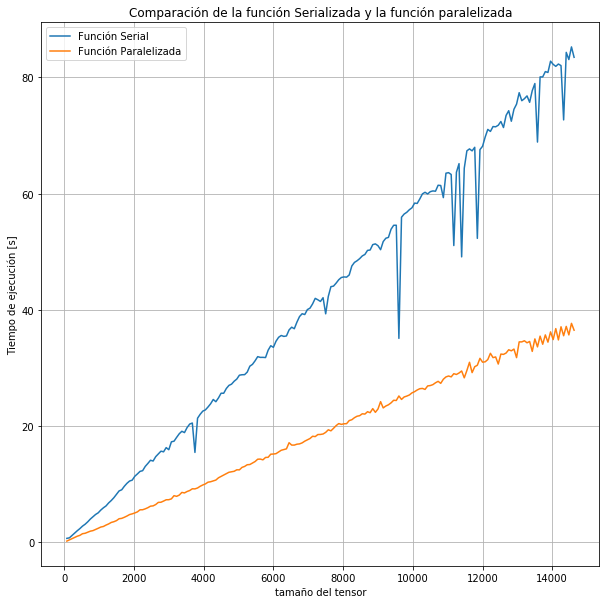

In [60]:
plt.figure(figsize = (10,10))
plt.plot(cantidadDePuntos[:-1],tiempoSerial,label = "Función Serial")
plt.plot(cantidadDePuntos[:-1],tiempoParalelo,label = "Función Paralelizada")
plt.legend()
plt.title("Comparación de la función Serializada y la función paralelizada")
plt.ylabel("Tiempo de ejecución [s]")
plt.xlabel("tamaño del tensor")
plt.grid()
plt.savefig("SerializadaVsParalela1D",dpi=300)

### Optimización con la función de perdida paralela

In [62]:
learning_rate = 1e-4
epochs = 8000
optimizer = torch.optim.Adam(redDinamica.parameters(), lr=learning_rate)
#registro_perdida=[]
tiempoInicial = time.time()
i = 0
while time.time()-tiempoInicial<3600/60*15:
    # Compute prediction and loss
    loss = perdidaParalela()
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        print(loss.item()/len(puntos))
        #print("supermax",promAct)
        actualizarPuntos()
    registro_perdida.append(loss.item()/len(puntos))
    i+=1

0.19674134792241835
promedio actual  tensor(1.0051, device='cuda:0', grad_fn=<AddBackward0>)
perdida actual   tensor(26.1666, device='cuda:0', grad_fn=<AddBackward0>)
avance           tensor(5.0828e-06, device='cuda:0', grad_fn=<MulBackward0>)
0.17805703006573578
promedio actual  tensor(1.0051, device='cuda:0', grad_fn=<AddBackward0>)
perdida actual   tensor(23.8596, device='cuda:0', grad_fn=<AddBackward0>)
avance           tensor(5.6162e-06, device='cuda:0', grad_fn=<MulBackward0>)
0.15868705466941552
promedio actual  tensor(1.0051, device='cuda:0', grad_fn=<AddBackward0>)
perdida actual   tensor(21.4228, device='cuda:0', grad_fn=<AddBackward0>)
avance           tensor(6.3017e-06, device='cuda:0', grad_fn=<MulBackward0>)
0.13843317592845245
promedio actual  tensor(1.0051, device='cuda:0', grad_fn=<AddBackward0>)
perdida actual   tensor(18.8269, device='cuda:0', grad_fn=<AddBackward0>)
avance           tensor(7.2237e-06, device='cuda:0', grad_fn=<MulBackward0>)
0.11826719854869981
prom

### Almacenamiento de las variables del cuaderno

In [67]:
del NeuralNetworkPrueba, redDinamica, miniPerdidaParalela, difeq
import dill
dill.dump_session("comparacionSerialNB")